In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import pickle
from scipy.stats import ks_2samp

from data import load_data
from deconv import nls_projgrad
from utilities import *

# from scvi.model import CondSCVI, DestVI
# import tangram as tg
# import novosparc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define your datasets
datasets = [
    # 'synthetic',
    # 'simu_spatial_rare',
    'xenium'
]

# Define shared parameters
thresholds = [
    '> Q3 + 1.5IQR',
    '> 90%',
    '> 95%',
    '> 99%'
]

In [18]:
results_saved, save_dict_to = ('recon_bench_xenium.pickle', None) # "recon_bench.pickle"
# results_df, save_df_to = (None, 'mapping_bench_xenium.csv') # 'mapping_bench.csv'

In [ ]:
if (results_saved == None) and (results_df == None):
    # Process and store results for each combination
    results = {}
    ent = {}
    total_counts_df = []
    for dataset in datasets:
        results[dataset] = {}
        ent[dataset] = {}

        tissue_saved, save_tissue = ('xenium_tissue.pkl', None) if dataset == 'xenium' else ('simu_spatial_tissue.pkl', None)
        
        # if dataset not in ['synthetic', 'simu_spatial']:
        #     tissue_saved, save_tissue = (None, dataset + '_tissue.pkl')
        
        # Compute common attributes for the current dataset and condition
        sc_adata, st_adata, num_cells, num_genes, num_locations = compute_attributes(dataset)
        df =  sc_adata.obs['cell_type'].value_counts().to_frame().rename(columns={'cell_type': 'total counts'})
        df['Dataset'] = dataset
        df = df.reset_index()
        df = df.rename(columns={'index': 'Cell Type'})
        total_counts_df.append(df)
        
        methods = [
            (mapping_only, (sc_adata, st_adata, num_cells, num_locations), 'mapping_only'),
            (novosparc_coupling, (sc_adata, st_adata, num_cells, num_genes, tissue_saved, save_tissue), 'novosparc_coupling'),
            (rand_coupling, (sc_adata, num_cells, num_locations), 'rand_coupling'),
        ]
        
        for method, args, name in methods:
            results[dataset][name] = {}

            coupling = method(*args)
            ent[dataset][name] = get_cell_entropy(coupling)

            for threshold in thresholds:
                # Define the number of processes to use
                num_processes = multiprocessing.cpu_count()

                def sum_category(category):
                    category_sum = 0
                    for i in range(num_cells):
                        if sc_adata.obs['cell_type'][i] == category:
                            category_sum += int(coupling.T[np.where(sc_adata.obsm['mapping'].to_numpy()[i] == 1)[0][0], i] in detect_outlier(coupling.T[:, i], threshold=threshold))
                    return category, category_sum

                def parallel_sum_categories(categories):
                    pool = multiprocessing.Pool(processes=num_processes)
                    results = pool.map(sum_category, categories)
                    pool.close()
                    pool.join()

                    category_sums = {category: 0 for category in categories}
                    for category, category_sum in results:
                        category_sums[category] = category_sum

                    return category_sums

                # Get the set of categories
                categories = set(sc_adata.obs['cell_type'])

                # Calculate the sums for each category in parallel
                category_sums = parallel_sum_categories(categories)

                # # Print the category sums
                # for category, category_sum in category_sums.items():
                #     print(f"{category}: {category_sum}")
                    
                results[dataset][name][threshold] = category_sums

    # Save dictionary to a file using pickle
    with open(save_dict_to, "wb") as file:
        pickle.dump(results, file)

    # Prepare data for plotting
    total_counts_df = pd.concat(total_counts_df)
    data_list = []
    for dataset, methods in results.items():
        for method, thresholds in methods.items():
            for threshold, values in thresholds.items():
                for cell_type, count in values.items():
                    data_list.append({'Dataset': dataset, 'Method': method, 'Threshold': threshold, 'Cell Type': cell_type, 'Count': count})
    df = pd.DataFrame(data_list)
    total_counts_df.rename(columns={'cell_type': 'Cell Type'}, inplace=True)
    df = pd.merge(df, total_counts_df, on=['Dataset', 'Cell Type'])
    df['Fraction'] = df['Count'] / df['total counts']
    # Group the dataframe by 'Dataset', 'Method', and 'Threshold', and calculate the sum of 'Count' and 'total counts'
    grouped_df = df.groupby(['Dataset', 'Method', 'Threshold'])[['Count', 'total counts']].sum()
    # Calculate the fraction and assign it to the 'fraction_all' column
    grouped_df['fraction_all'] = grouped_df['Count'] / grouped_df['total counts']
    # Merge the calculated values back to the original dataframe
    df = df.merge(grouped_df['fraction_all'].reset_index(), on=['Dataset', 'Method', 'Threshold'])
    df.to_csv(save_df_to)
else:
    if results_saved != None:
        with open(results_saved, "rb") as file:
            results = pickle.load(file)
    if results_df != None:
        df = pd.read_csv(results_df, index_col=0)

In [ ]:
num_bins = 100  # Define the number of bins for the histogram

for dataset, methods in ent.items():
    tit_size = 20
    fonts = 16
    fonts_ticks = 20

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    
    for method, entropy in methods.items():
        ax.hist(entropy, bins=num_bins, label=method, alpha=0.3, histtype='stepfilled')

    ax.set_title('Entropy distribution of transport matrices (' + dataset + ')', size=tit_size)
    ax.set_xlabel('Entropy', size=tit_size)
    lg = ax.legend(fontsize=fonts, loc='upper left', title='Methods')
    lg.get_title().set_fontsize(fonts)
    ax.tick_params(labelsize=fonts_ticks)
    
    # Get the handles (bars) and labels from the plot
    handles, labels = ax.get_legend_handles_labels()

    # Create a custom legend with the same colors as the plot
    plt.legend(handles=handles, labels=['scDOT', 'Novosparc'], title='Method')

    plt.show()
    
    print(ks_2samp(ent[dataset]['mapping_only'], ent[dataset]['novosparc_coupling']))

In [10]:
add_labels = True
save_plots_cell_type = None #'mapping_bench_cell_types.pdf'
save_plots_cells = None #'mapping_bench_cells.pdf'

In [ ]:
# Plot boxplots with dots
for dataset in datasets:
    plt.figure(figsize=(12, 8))
    sns.boxplot(
        data=df[df['Dataset'] == dataset], 
        x='Threshold', y='Fraction', hue='Method', 
        # palette='Set3', 
        dodge=True
        )
    # sns.stripplot(
    #     data=df[df['Dataset'] == dataset], 
    #     x='Threshold', y='Fraction', hue='Method', 
    #     jitter=True, 
    #     dodge=True, 
    #     linewidth=1, 
    #     size=4, 
    #     alpha=0.7
    #     )

    # Add labels to the dots
    if add_labels:
        for i in range(len(df)):
            x = df.iloc[i]['Threshold']
            y = df.iloc[i]['Fraction']
            cell_type = df.iloc[i]['Cell Type']
            plt.text(x, y, cell_type, ha='center', va='bottom', fontsize=8)
            
    plt.title(dataset)
    plt.xlabel('Threshold (for high probability)')
    plt.ylabel('Fraction of cells per cell type \n reconstructed to their spatial origins')
    # Get the handles (bars) and labels from the plot
    handles, labels = ax.get_legend_handles_labels()
    # Create a custom legend with the same colors as the plot
    plt.legend(handles=handles, labels=['scDOT', 'Novosparc', 'Random Sinkhorn'], title='Method')

    plt.savefig(dataset + save_plots_cell_type) if save_plots_cell_type else None
    plt.show()

# Set the figure size
plt.figure(figsize=(10, 6))

# Group the dataframe by 'Dataset', 'Threshold', and 'Method' and calculate the mean of 'fraction_all'
grouped_plot_df = df.groupby(['Dataset', 'Threshold', 'Method'])['fraction_all'].mean().reset_index()

# Generate the bar plot
sns.barplot(x='Threshold', y='fraction_all', hue='Method', data=grouped_plot_df)

# Set plot title and labels
plt.title('')
plt.xlabel('Threshold')
plt.ylabel('Fraction of cells \n reconstructed to their spatial origins')

# Get the handles (bars) and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Create a custom legend with the same colors as the plot
plt.legend(handles=handles, labels=['scDOT', 'Novosparc', 'Random Sinkhorn'], title='Method')

# Show the plot
plt.savefig(save_plots_cells) if save_plots_cells else None
plt.show()

# use Matplotlib’s get_legend_handles_labels() to remove redundant legends:
# https://datavizpyr.com/grouped-boxplot-with-jittered-data-points-with-seaborn/

In [31]:
# Define values you want to filter for each column
filter_values = {
    'Dataset': ['simu_spatial'],
    'Method': ['mapping_only'],
    'Threshold': ['iqr']
}

In [32]:
# Create boolean masks for each column
masks = [df[col].isin(filter_values[col]) for col in filter_values]

# Combine masks using logical AND
combined_mask = masks[0]
for mask in masks[1:]:
    combined_mask &= mask

# Apply the combined mask to filter the DataFrame
filtered_df = df[combined_mask]

In [34]:
sorted_df = filtered_df.sort_values(by='total counts')

In [35]:
sorted_df

,Dataset,Method,Threshold,Cell Type,Count,total counts,Fraction,fraction_all
122,simu_spatial,mapping_only,iqr,Submucosal Secretory,1,1,1.000000,0.760173
118,simu_spatial,mapping_only,iqr,2_Mesothelium,1,1,1.000000,0.760173
126,simu_spatial,mapping_only,iqr,Myofibroblasts,2,2,1.000000,0.760173
124,simu_spatial,mapping_only,iqr,Fibromyocytes,7,7,1.000000,0.760173
129,simu_spatial,mapping_only,iqr,SM activated stress response,7,8,0.875000,0.760173
121,simu_spatial,mapping_only,iqr,EC arterial,10,11,0.909091,0.760173
120,simu_spatial,mapping_only,iqr,EC venous,10,14,0.714286,0.760173
113,simu_spatial,mapping_only,iqr,Lymphatic EC differentiating,14,16,0.875000,0.760173
110,simu_spatial,mapping_only,iqr,2_Smooth muscle,16,20,0.800000,0.760173
114,simu_spatial,mapping_only,iqr,Basal,19,21,0.904762,0.760173


In [4]:
dataset = 'synthetic'
path = '../data/synthetic/'
sc_adata, st_adata = load_data(data='synthetic', path=path)
ctp = st_adata.obsm['true_deconvolution'].to_numpy()
# preprocess
sc.pp.normalize_per_cell(sc_adata)
num_cells, num_genes = sc_adata.shape

In [5]:
markers = st_adata.uns['markers'].to_numpy()
st = st_adata.X
ctp_deconv = nls_projgrad(markers.T, st.T)[0].T
ctp_deconv = ctp_deconv/ctp_deconv.sum(1)[:,None]

In [6]:
destvi_calculated, save_destvi_to = ('destvi_results.csv', None)
tangram_calculated, save_tangram_to = ('tangram_results.csv', None)
novosparc_calculated, save_novosparc_to = ('novosparc_results.csv', None)

In [7]:
if destvi_calculated == None:
    CondSCVI.setup_anndata(sc_adata, labels_key="annotations")
    reference_model_destvi = CondSCVI(sc_adata, weight_obs=True)

    reference_model_destvi.train(max_epochs=50)
    reference_model_destvi.history["elbo_train"][10:].plot()

    DestVI.setup_anndata(st_adata)
    mixture_model_destvi = DestVI.from_rna_model(st_adata, reference_model_destvi)
    mixture_model_destvi.train(max_epochs=50)
    mixture_model_destvi.history["elbo_train"][10:].plot()

    celltype_preds_mixture_destvi = mixture_model_destvi.get_proportions()
    celltype_preds_mixture_destvi = (celltype_preds_mixture_destvi.T / celltype_preds_mixture_destvi.T.sum(0)).T

    preds_destvi = celltype_preds_mixture_destvi
    preds_destvi.to_csv(save_destvi_to)
else:
    preds_destvi = pd.read_csv(destvi_calculated, index_col=0).to_numpy()

if tangram_calculated == None:
    tg.pp_adatas(sc_adata, st_adata)
    ad_map = tg.map_cells_to_space(sc_adata, st_adata, mode='clusters', cluster_label="cell_type")
    tg.project_cell_annotations(ad_map, st_adata, annotation = "cell_type")
    preds_tangram = (st_adata.obsm['tangram_ct_pred'].T / st_adata.obsm['tangram_ct_pred'].T.sum(0)).T
    preds_tangram.to_csv(save_tangram_to)
else:
    preds_tangram = pd.read_csv(tangram_calculated, index_col=0).to_numpy()

if novosparc_calculated == None:
    tissue_saved, save_tissue = ('tissue.pkl', None) if dataset == 'synthetic' else ('simu_spatial_tissue.pkl', None)
    if dataset not in ['synthetic', 'simu_spatial']:
        tissue_saved, save_tissue = (None, dataset + '_tissue.pkl')
    coupling = novosparc_coupling(sc_adata, st_adata, num_cells, num_genes, tissue_saved, save_tissue)
    preds_novosparc = coupling.T @ sc_adata.obsm['cell_type']
    preds_novosparc = preds_novosparc/preds_novosparc.sum(1)[:,None]
    preds_novosparc = preds_novosparc.set_index(st_adata.obs_names)
    preds_novosparc.to_csv(save_novosparc_to)
else:
    preds_novosparc = pd.read_csv(novosparc_calculated, index_col=0).to_numpy()

In [8]:
save_plot_to = None

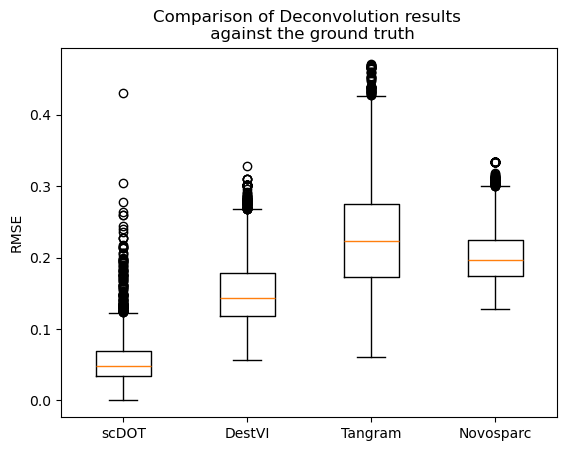

0.05601513898534196 0.15324336663341473 0.23036045322725543 0.2041952138186801


In [9]:
rmse_scDOT = np.sqrt(((ctp_deconv - ctp)**2).mean(1))
rmse_destvi = np.sqrt(((preds_destvi - ctp)**2).mean(1))
rmse_tangram = np.sqrt(((preds_tangram - ctp)**2).mean(1))
rmse_novosparc = np.sqrt(((preds_novosparc - ctp)**2).mean(1))

# Combine the data into a list
data = [rmse_scDOT, rmse_destvi, rmse_tangram, rmse_novosparc]
# Create a figure and axis object
fig, ax = plt.subplots()
# Plot the boxplots
ax.boxplot(data)
# Add labels to the x-axis
ax.set_xticklabels(['scDOT', 'DestVI', 'Tangram', 'Novosparc'])
# Set the y-axis label
ax.set_ylabel('RMSE')
# Add a title
ax.set_title('Comparison of Deconvolution results \n against the ground truth')
# Display the plot
plt.savefig(save_plot_to) if save_plot_to != None else None
plt.show()

print(
    rmse_scDOT.mean(), 
    rmse_destvi.mean(), 
    rmse_tangram.mean(), 
    rmse_novosparc.mean()
)

In [35]:
save_plot_PCC_to = 'pcc.svg'

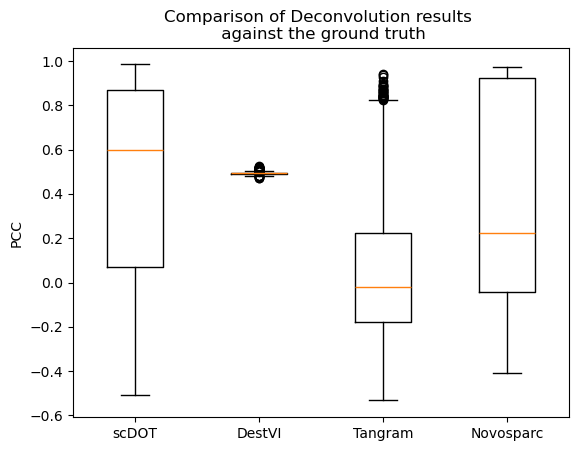

0.47111183586198263 0.4937057718663183 0.045409936704741534 0.37107051476171754


In [37]:
from scipy.stats import pearsonr

pcc_scDOT = np.apply_along_axis(lambda x: pearsonr(x, ctp[x.ndim - 1, :])[0], axis=1, arr=ctp_deconv)
pcc_destvi = np.apply_along_axis(lambda x: pearsonr(x, ctp[x.ndim - 1, :])[0], axis=1, arr=preds_destvi)
pcc_tangram = np.apply_along_axis(lambda x: pearsonr(x, ctp[x.ndim - 1, :])[0], axis=1, arr=preds_tangram)
pcc_novosparc = np.apply_along_axis(lambda x: pearsonr(x, ctp[x.ndim - 1, :])[0], axis=1, arr=preds_novosparc)

# Combine the data into a list
data = [pcc_scDOT, pcc_destvi, pcc_tangram, pcc_novosparc]
# Create a figure and axis object
fig, ax = plt.subplots()
# Plot the boxplots
ax.boxplot(data)
# Add labels to the x-axis
ax.set_xticklabels(['scDOT', 'DestVI', 'Tangram', 'Novosparc'])
# Set the y-axis label
ax.set_ylabel('PCC')
# Add a title
ax.set_title('Comparison of Deconvolution results \n against the ground truth')
# Display the plot
plt.savefig(save_plot_PCC_to) if save_plot_PCC_to != None else None
plt.show()

print(
    pcc_scDOT.mean(), 
    pcc_destvi.mean(), 
    pcc_tangram.mean(), 
    pcc_novosparc.mean()
)